1_results_A_transect_figures.ipynb  
# Notebook for transect figures along GEOTRACES cruises

**Notebook input:**
- runs (from modeldir):
  - CTRL
  - Px1_18Sv
  - Px1_9Sv
  - Pdyn_9Sv 
- seawater observations (from obsdir): 
  - Pad_Thd_IDP2021.txt (geotraces dissolved)
  - Pap_Thp_IDP2021.txt (geotraces particle-bound)
  - Deng2018Pad_Thd_formatted_uBq_per_kg.csv
  - Ng2020Pad_Thd_formatted_dpm_per_1000kg.csv
  - Pavia2020Pad_Thd_formatted_uBq_per_kg.csv

**Notebook output (written to savedir):**
- Fig. 3c,d
- a figure with model-data comparison of 1 cruise and 1 run (free to choose in settings)
- Fig. C2-C3
- Fig. 5
- Fig. C1
- Fig. 11
- intermediate versions xxx_raw.pdf and xxx_uncropped.pdf of these figures

**Notebook comments:**   
- This notebook makes the transect/section plots along trajectories. 
- In addition to the usual functions.py, additional plotting routines are used from plot_gruber.py, plot_profile.py and plot_surface.py.
- For this notebook you need a manual step using command line tools pfdjam & pdfcrop (as indicated where applicable)
- Fig. 5 and C1 can easily be plotted for another run than CTRL, by just changing the runname in the settings (at top of cell of respective plot).

**General information:**
- This notebook was published in the zenodo repository https://doi.org/10.5281/zenodo.10622403 along with the paper:

   - Jeemijn Scheen, Jörg Lippold, Frerk Pöppelmeier, Finn Süfke and Thomas F. Stocker. Promising regions for detecting the overturning circulation in Atlantic 231Pa/230Th: a model-data comparison. Paleoceanography and Paleoclimatology, 2025.
- Notebook author: Jeemijn Scheen, jeemijn.scheen@nioz.nl
- Author of functions used for transect plotting (imported from plot_gruber.py; plot_profile.py; plot_surface.py): Gunnar Janssen, gunnar.jansen@unibe.ch

# Set up notebook  

**Easiest:** load conda environment for which this notebook worked.  
**Just use environment.yml (present in this folder) and follow** https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file

In [1]:
from pathlib import Path         # Path objects to avoid inter-platform trouble in file paths
import platform

########## SET FILE PATHS ######################################
# KEEP THE Path() FUNCTION AND USE FORWARD SLASHES '/' ON EVERY OPERATING SYSTEM
savedir = Path('./figures/')      # folder for saving figures & other output; (empty) directory needed
obsdir = Path('./data/')          # obs. data is loaded from here
modeldir = Path('./modeloutput/') # model output is loaded from here
#############################################

## CHECK FILEPATHS
# expand paths because np.loadtxt can't handle home directory ~
savedir = savedir.expanduser()
obsdir = obsdir.expanduser()
modeldir = modeldir.expanduser()
def check_dir(path):
    if not path.exists():
        raise Exception('File path ' + str(path) + ' does not exit. Correct or create first.')
check_dir(savedir)
check_dir(obsdir)
check_dir(modeldir)

## IMPORT PACKAGES
# first time install missing packages via $conda install numpy OR $pip3 install numpy (be consistent)
import numpy as np
import xarray as xr                            # $conda install -c anaconda -n cartopy xarray; needs some time
import pandas as pd
import importlib as imp                        # to import user-defined functions; renaming new name to name of deprecated package 'imp'
import math                                    # math.e or math.exp()
import xesmf as xe                             # regridding; install via conda-forge channel e.g. !conda install -c conda-forge xesmf -y
import shutil                                  # used for shell commands for pdfjam

# plot-related packages:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace
import matplotlib.cm as cmp                    # colormaps
import cmcrameri.cm as cmcr                    # better colour maps (https://www.fabiocrameri.ch/colourmaps/); $conda install -c conda-forge cmcrameri
import cartopy.crs as ccrs
import seaborn as sns

## CHECK PYTHON VERSION
if 1/2 == 0:
    raise Exception("You are using python 2. Please use python 3 for a correct display of the figures.") 

## PLOT SETTINGS
# larger labels
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## PREPARE TRANSECT PLOTTING 
# (originally based on Nikki Gruber's idea to plot Atl+SO+Pac together)
from plot_surface import Surface
from plot_gruber import Gruber
from plot_profile import Profile
# needed for combining figures with pdfjam:
from matplotlib.backends.backend_pdf import PdfPages

# cmap = cmp.coolwarm
cmap = cmcr.lapaz_r


# SET TIME OF INTEREST
# time step of interest in all cells below
t = -1

# set a random run as control simulation; doesn't matter as only model grid is used
fnctrl = modeldir / 'CTRL_NEWNR'

## LOAD USER-DEFINED FUNCTIONS
import functions as f                          # my own functions; call via f.function_name()

In [2]:
imp.reload(f)   # shows how to reload functions after editing functions.py w/o kernel restart

<module 'functions' from '/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py'>

# Load runs    

In [3]:
## ORGANIZE RUNNAMES & LABELS:
# SAVE ORIGINAL RUNNAMES IN CLEARER VARIABLES WITH CLEARER RUNNAMES

########### RESULT OF TUNING RUNS #################################################
ctrl = 'CTRL_NEWNR'                    # control run (new during review; with No Remineralization term, NR)
NO_NEPH = 'NO_NEPH___'                 # with sigma_nephs = 0
NO_DUST = 'NO_DUST___'                 # with sigma_dusts = 0
ADD_REM = 'CTRL_NEWYR'                 # with added remineralization term (as in tuning); dont use, only check
# (an extra Remin. term was still present during tuning; this term was dropped from other runs during review)

########### FACTORIAL RUNS: VARYING AMOC AND/OR PARTICLE FIELDS ###################
## weak AMOC spinups
# not used in manuscript directly; are 'spinups' to adjust to FW forcing; from those runs PFREE_14SV etc are started
weak_AMOC7 = 'WEAK_010SV'   # FW forcing of 0.10 Sv in NAtl; compensated; gives 14.0 Sv AMOC is 79%; free particles
weak_AMOC6 = 'WEAK_015SV'   # FW forcing of 0.15 Sv in NAtl; compensated; gives 11.2 Sv AMOC; free particles
weak_AMOC5 = 'WEAK_020SV'   # FW forcing of 0.20 Sv in NAtl; compensated; gives 8.6 Sv AMOC is 48%; free particles

# weak AMOC, with free=dynamic particles
# PFREE_18SV = ctrl         # already exists
PFREE_14SV = 'PFREE_14SV'   # AMOC of ca 14 Sv (so 0.10Sv FW and restart from WEAK_010SV); particle field (PF) free
PFREE_11SV = 'PFREE_11SV'   # AMOC of ca 11 Sv (so 0.15Sv FW and restart from WEAK_015SV); particle field (PF) free
PFREE_09SV = 'PFREE_09SV'   # AMOC of ca 9 Sv (so 0.20Sv FW and restart from WEAK_020SV); particle field (PF) free

# 18 Sv AMOC (PI), scaling particle export
PFX1__18SV = 'PFX1__18SV'
PFX2__18SV = 'PFX2__18SV'
PFX3__18SV = 'PFX3__18SV'
PFX5__18SV = 'PFX5__18SV'
PFD2__18SV = 'PFD2__18SV'

# weak AMOC, scaling particle export
PFD2__14SV = 'PFD2__14SV'   # AMOC of ca 14 Sv (so 0.10Sv FW and restart from WEAK_010SV); particle field divided by 2
PFD2__11SV = 'PFD2__11SV'   # AMOC of ca 11 Sv (so 0.15Sv FW and restart from WEAK_015SV); particle field divided by 2
PFD2__09SV = 'PFD2__09SV'   # AMOC of ca 9 Sv (so 0.20Sv FW and restart from WEAK_020SV); particle field divided by 2

PFX1__14SV = 'PFX1__14SV'   # AMOC of ca 14 Sv; particle field multiplied by 1 
PFX1__11SV = 'PFX1__11SV'   # i.e. same particles as CTRL but w/o seasonal cycle
PFX1__09SV = 'PFX1__09SV'   # (difference is not/barely visible in yearly average effects) 

PFX2__14SV = 'PFX2__14SV'   # AMOC of ca 14 Sv; particle field multiplied by 2
PFX2__11SV = 'PFX2__11SV'   # etc.
PFX2__09SV = 'PFX2__09SV'

PFX3__14SV = 'PFX3__14SV'
PFX3__11SV = 'PFX3__11SV'
PFX3__09SV = 'PFX3__09SV'

PFX5__14SV = 'PFX5__14SV'
PFX5__11SV = 'PFX5__11SV'
PFX5__09SV = 'PFX5__09SV'
##################################################################################

# set labels used in figures:
labels = {ctrl:'CTRL', NO_DUST: 'NO_DUST', NO_NEPH: 'NO_NEPH', ADD_REM: 'ADD_REM', 
          PFX1__18SV: 'Px1_18Sv', PFX2__18SV: 'PART X2', PFX3__18SV: 'PART X3', 
          PFX5__18SV: 'PART X5', PFD2__18SV: 'PART X0.5', 
          PFREE_14SV: 'Pdyn_14Sv', PFREE_11SV: 'Pdyn_11Sv', PFREE_09SV: 'Pdyn_9Sv',
          PFD2__14SV: 'P/2_14Sv', PFD2__11SV: 'P/2_11Sv', PFD2__09SV: 'P/2_9Sv',
          PFX1__14SV: 'Px1_14Sv', PFX1__11SV: 'Px1_11Sv', PFX1__09SV: 'Px1_9Sv',
          PFX2__14SV: 'Px2_14Sv', PFX2__11SV: 'Px2_11Sv', PFX2__09SV: 'Px2_9Sv',
          PFX3__14SV: 'Px3_14Sv', PFX3__11SV: 'Px3_11Sv', PFX3__09SV: 'Px3_9Sv',
          PFX5__14SV: 'Px5_14Sv', PFX5__11SV: 'Px5_11Sv', PFX5__09SV: 'Px5_9Sv',
          weak_AMOC5: '0.20Sv FW NAtl', weak_AMOC6: '0.15Sv FW NAtl', weak_AMOC7: '0.10Sv FW NAtl', 
          }

# in the model output simulation year 0 is called 1765 CE (pre-industrial)
yr = '.0001765'
spinup_yr = 1765

In [4]:
## LOAD RUNS

########### SETTINGS ########################################
# FOR ALL FIGS IN THIS NOTEBOOK: 
# Fig. 5, C1 (they use CTRL) and Fig. 11 (also uses the other 3 runs):
runs = [ctrl, PFX1__18SV, PFX1__09SV, PFREE_09SV]

# OTHER SETS OF RUNS TO PLAY AROUND:
# runs = [PFX1__18SV, PFX1__14SV, PFX1__09SV]
# runs = [ctrl, PFREE_14SV, PFREE_09SV]
##############################################################

[datas, data_fulls] = f.load_data_multiple_runs(modeldir, runs, spinup_yr, 
                                                z_in_km=True, add_more_PaTh_vars=True)
#### INFO ####
# - timeseries data are loaded into 'datas' and have annual resolution
# - 3D variables are loaded into 'data_fulls' with lower time resolution, or only the last time step
# datas & data_fulls are dicts with keys=runnames, values=Xarray Dataset with model output of that run
##############

# Prepare landmask for surface plots
land_mask = f.get_landmask(data_fulls[runs[0]])  # doesn't matter which run (only uses model grid)

# Load observations  
Seawater observations:   
- 'obs_d': contains dissolved Pa, Th as in tuning notebooks, i.e., from Ng et al., Deng et al., Pavia et al. and GEOTRACES (all cruises except Arctic)
- 'obs_p': contains particle-bound Pa, Th as in tuning notebooks, i.e., from GEOTRACES (all cruises except Arctic)   

In [5]:
## SEAWATER OBS  ################################### TAKES A WHILE (e.g. 2 minutes) ###########

## DISSOLVED SEAWATER OBS ##########################

# load geotraces ICP 2021 observations; has lon [0,360]
fnobs = obsdir / 'Pad_Thd_IDP2021.txt'
obs_d_geotraces = f.get_obs_geotraces(fnobs, dissolved_type='BOTTLE', 
                                      drop_meta_data=True, good_quality=True)
# STILL INCLUDES ARCTIC: AS WE WANT IN (ONLY) THIS NOTEBOOK s.t. you can still make plots of 'GN01' etc

# load other dissolved observations from 3 additional studies
obs_d_deng = f.get_obs_other(obsdir / 'Deng2018Pad_Thd_formatted_uBq_per_kg.csv') # is geovide
obs_d_ng = f.get_obs_other(obsdir / 'Ng2020Pad_Thd_formatted_dpm_per_1000kg.csv')
for var in ['Pad','Pad_err','Thd','Thd_err']:
    # convert dpm/1000kg to uBq/kg; using 1 dpm = 1/60 * 1e6 uBq
    obs_d_ng[var] = obs_d_ng[var] / 60.0 * 1e3  
obs_d_pavia = f.get_obs_other(obsdir / 'Pavia2020Pad_Thd_formatted_uBq_per_kg.csv')

# combine all dissolved data
obs_d = pd.concat([obs_d_geotraces,obs_d_deng,obs_d_ng,obs_d_pavia], join='outer')

# add column with ratio
obs_d['path_ratio_d'] = obs_d.Pad / obs_d.Thd

# easier to grab panda coords if lat,lon,z are not an index 
# => average obs to model grid
[obs_d, obs_d_ave, obs_d_ave_num] = f.obs_to_model_grid(obs_d, fnctrl)
obs_d.reset_index(inplace=True)


## PARTICLE-BOUND SEAWATER OBS ##########################
fnobs = obsdir / 'Pap_Thp_IDP2021.txt'
obs_p = f.get_obs_geotraces(fnobs, drop_meta_data=True, p_type='combined', good_quality=True)
# STILL INCLUDES ARCTIC: AS WE WANT IN (ONLY) THIS NOTEBOOK s.t. you can still make plots of 'GN01' etc

# add column with ratio
obs_p['path_ratio_p'] = obs_p.Pap / obs_p.Thp

# easier to grab panda coords if lat,lon,z are not an index 
# => average obs to model grid
[obs_p, obs_p_ave, obs_p_ave_num] = f.obs_to_model_grid(obs_p, fnctrl)
obs_p.reset_index(inplace=True)
obs_p_ave['path_ratio_p'] = obs_p_ave.Pap / obs_p_ave.Thp   # easy way to make Pap/Thp figure along GA03 and GA02

/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py:700: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv(fnobs, sep='\t', header=39, dtype={'Cruise Aliases':'str'})


Column 21 has mixed types as it contains quality control variables, which can be int or string. Fine.
Reduced dataset from  96184  rows to  2166  rows after deleting nans.
Reduced dataset from  129  rows to  129  rows after deleting nans.
Reduced dataset from  20  rows to  20  rows after deleting nans.
Reduced dataset from  126  rows to  126  rows after deleting nans.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Reduced dataset from  102686  rows to  860  rows after deleting nans.
Reduced dataset from  1009  rows to  1003  rows after deleting nans.
obs_to_model_grid(): found 'Pap' as well as 'path_ratio_p' in obs.columns; continuing with Pap.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_gr

# Prepare cruise tracks/trajectories

**Not all cruises measured Pa and/or Th**  
Namely, dissolved Pa and/or Th was measured in:  
- 'GA02', 'GAc02','GA03', 'GA10', 'GIPY04', 'GIPY05', 'GIpr05','GN01', 'GN02', 'GN03', 'GN04', 'GP16', 'GPc01', 'GSc02', 'deng','ng', 'pavia'  

And particle-bound Pa and/or Th in this subset:  
- 'GA03', 'GIPY04', 'GIPY05', 'GN01', 'GP16'  

Moreover, in our tuning and analysis we discarded the Arctic cruises 'GN01', 'GN02', 'GN03', 'GN04'.  
So, **cruises of interest for Pa and Th are:**
- **'GA02', 'GAc02','GA03', 'GA10', 'GIPY04', 'GIPY05', 'GIpr05','GP16', 'GPc01', 'GSc02', 'deng', 'ng', 'pavia'**

In [6]:
# GOAL: determine cruise tracks of the different geotraces and other studies on the Bern3D grid => for section plots
# We use multiple functions made for this purpose, which load in the lon, lat coordinates of each dataset + data processing.
# These coords are then transfered to the Bern3D grid. Plots per cruise of the 'regridded' track are made. 
# The coordinates are saved in such a way that they can be used for Section plots.
# Additional information about each cruise is kept in the datasets.

coords_all = f.get_all_cruise_coords(obsdir=obsdir, fnctrl=fnctrl)

/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py:2108: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv(fnobs, sep='\t', header=39, dtype={'Cruise Aliases':'str'})


Column 21 has mixed types as it contains quality control variables, which can be int or string. Fine.


Manual adjustments to cruise tracks (in the cell below):
- **dropped non-relevant (i.e. w/o Pa/Th measurements) side branches of cruises GA02 & GA03** , i.e. when a cruise branched off somewhere and then came back to the main track.  
- extra manual sorting in function sort_coords_per_cruise() for a few cruises where the default sorting (on lat and lon) was not logical enough.  
The extra manual sorting doesn't change the content, but only makes the order in which we walk through the water columns more logical.
- The original trajectory can be retreived with settings drop_non_relevant_side_branches=False & sort_extra_manual=False.  

In [8]:
## Organize together in a dict 'model_coords_per_cruise' ####################
model_coords_per_cruise = f.sort_coords_per_cruise(coords_all, 
                                                   drop_non_relevant_side_branches=True, 
                                                   sort_extra_manual=True)
# settings used in manuscript: drop_non_relevant_side_branches=True, sort_extra_manual=True

GA02 has 51 indices before dropping side branches.
GA02 has 42 indices after dropping side branches.
GA03 has 27 indices before dropping side branches.
GA03 has 20 indices after dropping side branches.


### Fig. 3 c,d: trajectory maps
Are combined with panel a and b in fig3_maps.pptx

i:   lon_t:     lat_t:
1    286.0      27.5
2    286.0      32.5
3    293.5      37.5
4    293.5      32.5
5    293.5      27.5
6    300.5      32.5
7    300.5      27.5
8    307.5      27.5
9    314.5      27.5
10    321.5      22.5
11    321.5      17.5
12    328.5      17.5
13    335.5      17.5
14    342.5      17.5
15    335.5      22.5
16    335.5      27.5
17    335.5      32.5
18    342.5      32.5
19    342.5      37.5
20    349.5      37.5


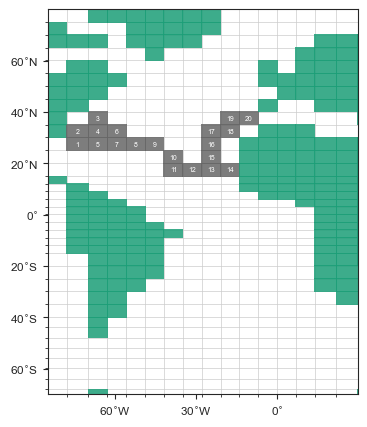

In [9]:
# plot trajectory on Bern3D grid (using functions.py which uses plot_gruber.py)
# Fig. 3c, d are with GA02 and GA03

##################### SETTINGS ######################################################
cruise = 'GA03'  # pick from: 'GA02','GAc02','GA03','GA10','GIPY04','GIPY05','GIpr05','GP16','GPc01','GSc02','deng','ng','pavia'
verbose = True   # prints lon/lat coordinates
grid_lines = True
##################### END OF SETTINGS ###############################################

## plot trajectory
basic_data_trajectory = [data_fulls[runs[0]], t, model_coords_per_cruise, cmap] # preparation; run only used for grid
fig = f.generate_trajectory_fig(cruise=cruise, basic_data=basic_data_trajectory, verbose=verbose)

## adjust size etc. to Fig. 3a
ax = fig.axes[0]
fig.set_size_inches(4,5) # set size to match Fig. 3a,b

if grid_lines:
   from matplotlib import ticker
   # add lines according to Bern3D model grid
   # place minor ticks on every grid point such that they appear in grid
   ax.xaxis.set_major_locator(ticker.FixedLocator([270,300,330,360]))
   ax.set_xticklabels([-90,-60,-30,0])
   ax.xaxis.set_minor_locator(ticker.FixedLocator(data_fulls[runs[0]].lon_u.values + 1e-2)) # adding an epsilon s.t. minor and major ticks don't coincide because ...
   # ... I use minor ticks for grid lines & major ticks for tick labels. However, matplotlib suppresses minor ticks when they coincide with major ticks.
   ax.yaxis.set_major_locator(ticker.FixedLocator(range(-60,70,30)))
   ax.yaxis.set_minor_locator(ticker.FixedLocator(data_fulls[runs[0]].lat_u.values + 1e-2))
   ax.grid("on", which='minor', lw=0.5)

ax.set_title("")

# set domain & yticks equal to Fig. 3a (map of cores):
ax.set_xlim(275,390)  # domain [85W, 30E] is [275,390] in Bern3D coordinates
ax.set_ylim(-70,80)
ax.set_yticks(range(-60,70,20))

# add '°W' etc
ax = f.convert_ticks_of_map(ax, Bern3D_grid=True, font="Arial")

# smaller ticklabels
ax.tick_params(axis='x', labelsize=8.5)
ax.tick_params(axis='y', labelsize=8.5)

if cruise == 'GA02':
   plt.savefig(savedir / ('fig3c_map_' + cruise + '.pdf'))
elif cruise == 'GA03':
   plt.savefig(savedir / ('fig3d_map_' + cruise + '.pdf'))
else:
   plt.savefig(savedir / ('map_' + cruise + '.pdf'))

# Section/transect plots

## Fig. C2-C3: Section/transect plots of Pap/Thp

run: CTRL_NEWNR
cruise: GA03


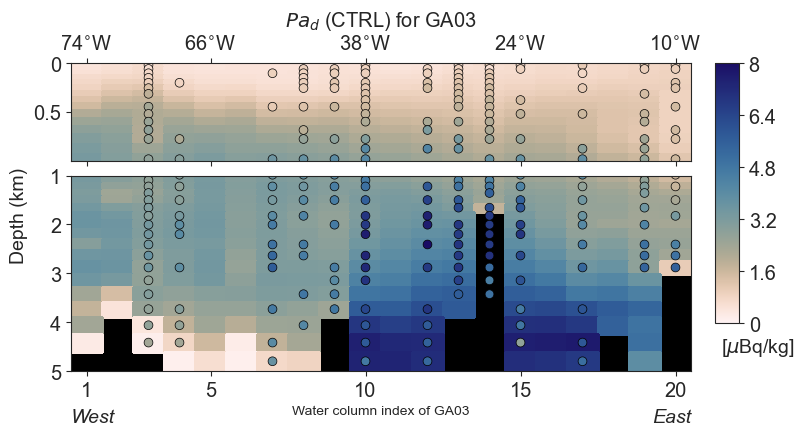

In [10]:
# 1 PANEL SECTION PLOT (using functions.py which uses plot_gruber.py)
# Can play around with run, cruise and variable
# Fig. C2 is generated with 'ctrl', 'GA03' and 'path_ratio_p'
# Fig. C3 is generated with 'ctrl', 'GIPY05' and 'path_ratio_p'
# The 'path_ratio_p' cannot be plotted along other transects, because of no Pap and/or Thp seawater data (GIVES ERROR)

##################### SETTINGS ######################################################
run = ctrl
cruise = 'GA03'       # pick from: 'GA02','GAc02','GA03','GA10','GIPY04','GIPY05','GIpr05','GP16','GPc01','GSc02','deng','ng','pavia'
variable = 'Pad_Bq'   # pick from: 'Pad_Bq', 'Thd_Bq', 'Pap_Bq', 'Thp_Bq', 'path_ratio_d', 'path_ratio_p'

cmap = cmcr.lapaz_r
this_vmin = 0.0
vmaxs = {'Pad_Bq' : 8, 'Thd_Bq' : 25, 'Pap_Bq' : 0.2, 'Thp_Bq' : 2,
         'path_ratio_d' : 1, 'path_ratio_p' : 0.2}
obs = True         # plot observations in circles on top of model output
verbose = False    # for debugging
##################### END OF SETTINGS ###############################################
print('run:', run)
print('cruise:', cruise)

basic_data_section = [t, model_coords_per_cruise, cmap, obs_d_ave, obs_p_ave]
var_label = {'Pad' : '$Pa_d$', 'Pap' : '$Pa_p$', 'Thd' : '$Th_d$', 'Thp' : '$Th_p$',
             'Pad_Bq' : '$Pa_d$', 'Pap_Bq' : '$Pa_p$', 'Thd_Bq' : '$Th_d$', 'Thp_Bq' : '$Th_p$',
             'path_ratio_p' : '$Pa_p/Th_p$', 'path_ratio_d' : 'Pa_d/Th_d'}
this_title = var_label[variable]+' ('+labels[run]+')'

this_title = var_label[variable]+' ('+labels[run]+')' + ' for ' + cruise

fig = f.generate_1_section_plot_fig(dataset=data_fulls[run], variable=variable, title=this_title,
                                    cruise=cruise, basic_data=basic_data_section, this_vmin=this_vmin, 
                                    vmaxs=vmaxs, obs=obs, verbose=verbose)

# save figure with appropriate name/number
if run == ctrl and variable == 'path_ratio_p':
   if cruise == 'GA03':
      fig_prefix = 'figC2_'
   elif cruise == 'GIPY05':
      fig_prefix = 'figC3_'
   else:
      fig_prefix = ''
else:
   fig_prefix = ''

plt.savefig(savedir / (fig_prefix + cruise + '_' + run + '_' + variable + '.pdf'))

## Fig. 5, C1: combine multiple section/transect plots 
The command line tools pdfjam and pdfcrop need to be installed for this.  
#### Why is combining pdfs with pdfjam tool needed?
- We want to combine multiple panels for multiple variables and/or runs and/or trajectories.
- With the current plotting routines, 1 section plot (as above) already consists of multiple subplots, so we cannot simply use subplots.  
- Therefore we use pdfjam to combine the generated pdfs of each desired panel. Then we use pdfcrop to crop away whitespace.   

#### Steps to generate the multi-panel section/transect plots
1. Make sure you have the command line tools pdfjam and pdfcrop installed (try by '$ pdfjam --version'). You can install them separately, or e.g. on OS X as part of the texlive package (texlive-latex-recommended) via macports.
2. Run the cells in the notebook as desired. 
3. The notebook cell prints out the terminal commands needed. Copy over in the terminal.
4. Open resulting pdf with pdf viewer to check. 

**For 1 cruise (and run) of choice - with panels of transect maps**

run: CTRL_NEWNR
cruise: GA03

In order to combine the 6 subpanels & crop white space:

!!!!!! THE FOLLOWING 2 LINES NEED TO BE EXECUTED IN THE COMMAND LINE (from the folder of this notebook): !!!!!
pdfjam --nup 3x2 figures/GA03_all_CTRL_NEWNR_raw.pdf --outfile figures/GA03_all_CTRL_NEWNR_uncropped.pdf
pdfcrop figures/GA03_all_CTRL_NEWNR_uncropped.pdf figures/GA03_all_CTRL_NEWNR.pdf

After that manual step, the resulting figure will be figures/GA03_all_CTRL_NEWNR.pdf


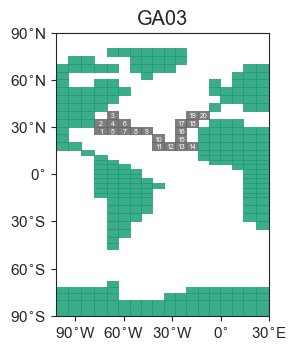

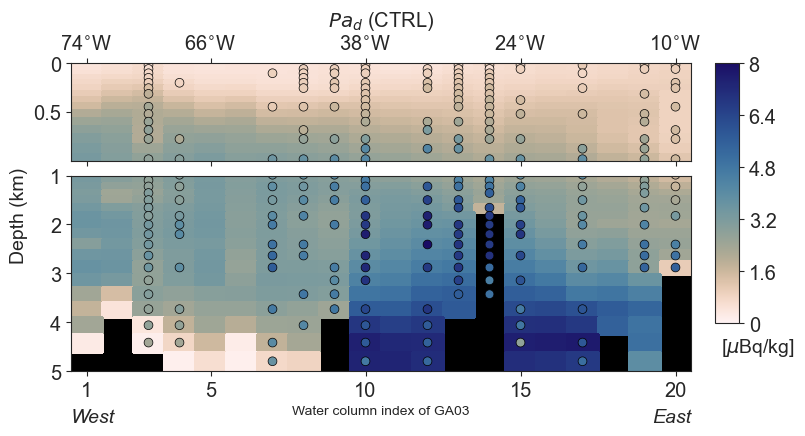

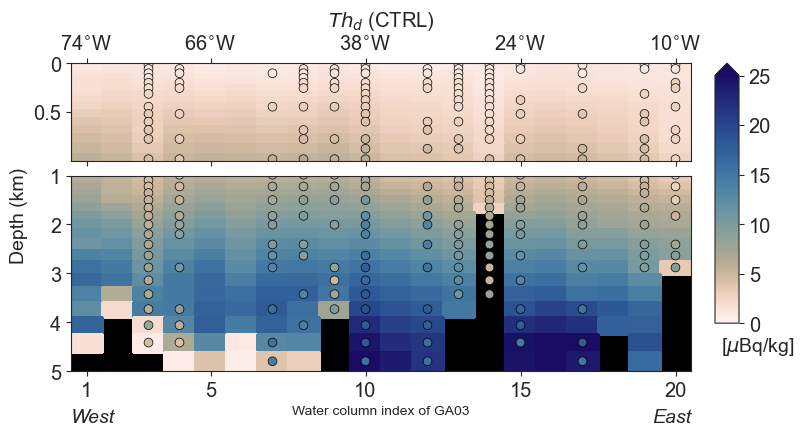

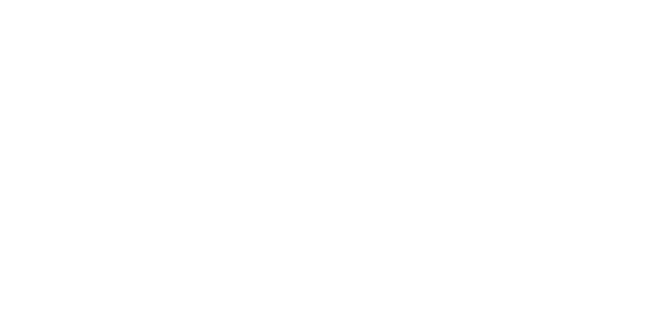

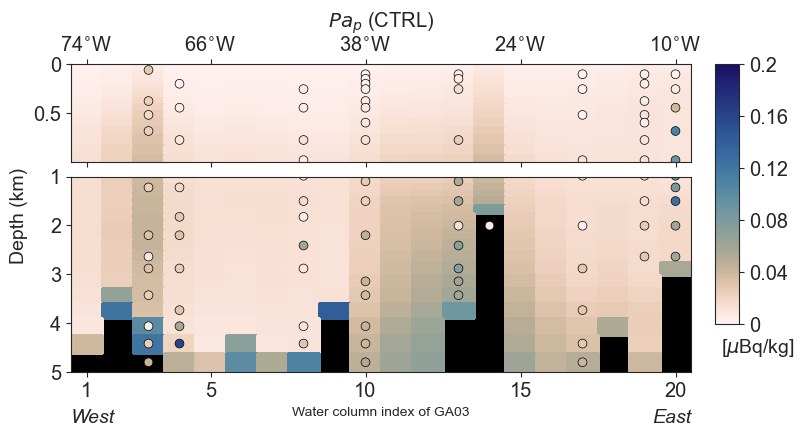

In [11]:
## FIRST COMBINE ALL PLOTS INCL. TRAJECTORY MAP FOR 1 CRUISE 

########################## SETTINGS ############################################
run = ctrl
this_cruise = 'GA03'

out_file_name = str(savedir / (this_cruise + '_all_' + run))  # without .pdf; no spaces
cmap = cmcr.lapaz_r
this_vmin = 0.0
vmaxs = {'Pad_Bq' : 8, 'Thd_Bq' : 25, 'Pap_Bq' : 0.2, 'Thp_Bq' : 2,
         'path_ratio_d' : 1, 'path_ratio_p' : 0.2}
################################################################################
print('run:', run)
print('cruise:', this_cruise)

basic_data_section = [t, model_coords_per_cruise, cmap, obs_d_ave, obs_p_ave]
basic_data_trajectory = [data_fulls[run], t, model_coords_per_cruise, cmap]
var_label = {'Pad' : '$Pa_d$', 'Pap' : '$Pa_p$', 'Thd' : '$Th_d$', 'Thp' : '$Th_p$',
             'Pad_Bq' : '$Pa_d$', 'Pap_Bq' : '$Pa_p$', 'Thd_Bq' : '$Th_d$', 'Thp_Bq' : '$Th_p$',
             'path_ratio_p' : '$Pa_p/Th_p$', 'path_ratio_d' : 'Pa_d/Th_d'}

if this_cruise in ['GA03', 'GIPY04', 'GIPY05', 'GN01', 'GP16']:  # particle-bound obs. available
    p_available = True
    cruise_vars = ['Pad_Bq', 'Thd_Bq', 'Pap_Bq', 'Thp_Bq']
else:
    p_available = False
    cruise_vars = ['Pad_Bq', 'Thd_Bq']

with PdfPages(out_file_name+'_raw.pdf') as pdf:
    
    ## A). first generate trajectory map for this cruise WITH whitespace on the left (once)

    # temporarily change global parameter to NOT cut off whitespace
    matplotlib.rcParams['savefig.bbox'] = 'standard'

    fig = f.generate_trajectory_fig(cruise=this_cruise, basic_data=basic_data_trajectory)

    # overwriting the (2.5,4) for Atlantic zoom to (8,4) + extra width for cbar in transect plot:
    fig.set_size_inches(8.134,4)
    # start subplot rectangle at left=68.75% of width s.t. same ratio stays the same(5.5/8=0.6875); others s.t. align with transect plot
    plt.subplots_adjust(left=0.6875, right=0.95, top=0.858, bottom=0.15)
    pdf.savefig()

    # set back global parameter as desired in the rest of the notebook
    matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace

    if p_available:
        # save figure size of map
        map_width, map_height = fig.get_size_inches()
    
    ## B). then plot section for dissolved
    for this_var in ['Pad_Bq', 'Thd_Bq']:
        this_title = var_label[this_var]+' ('+labels[run]+')'
        fig = f.generate_1_section_plot_fig(dataset=data_fulls[run], variable=this_var, title=this_title,
                                            cruise=this_cruise, basic_data=basic_data_section, 
                                            this_vmin=this_vmin, vmaxs=vmaxs)
        pdf.savefig(bbox_inches='tight')
        
    if p_available:
        ## C). create 1 empty map figure to align
        fig, ax = plt.subplots(1,figsize=(map_width, map_height))
        ax.set_axis_off()
        pdf.savefig(fig)

        ## D). then plot section for particle-bound
        for this_var in ['Pap_Bq', 'Thp_Bq']:
            this_title = var_label[this_var]+' ('+labels[run]+')'
            fig = f.generate_1_section_plot_fig(dataset=data_fulls[run], variable=this_var, title=this_title,
                                                cruise=this_cruise, basic_data=basic_data_section, 
                                                this_vmin=this_vmin, vmaxs=vmaxs, avoid_negative=True)
            pdf.savefig(bbox_inches='tight')

## COMBINE SUBPLOTS INTO 1 PAGE WITH pdfjam & pdfcrop
print("\nIn order to combine the 6 subpanels & crop white space:\n")
print("!!!!!! THE FOLLOWING 2 LINES NEED TO BE EXECUTED IN THE COMMAND LINE (from the folder of this notebook): !!!!!")
if p_available:
    print('pdfjam --nup 3x2 '+out_file_name+'_raw.pdf --outfile '+out_file_name+'_uncropped.pdf')
else:
    print('pdfjam --nup 3x1 '+out_file_name+'_raw.pdf --outfile '+out_file_name+'_uncropped.pdf')
print('pdfcrop '+out_file_name+'_uncropped.pdf '+out_file_name+'.pdf')
print('\nAfter that manual step, the resulting figure will be '+out_file_name+'.pdf')

plt.close()

**Fig. 5 (Atl selected cruises) - without panels of transect maps**

run: CTRL_NEWNR
cruise list: ['GA02', 'GA03']

In order to combine the subpanels & crop white space:

!!!!!! THE FOLLOWING 2 LINES NEED TO BE EXECUTED IN THE COMMAND LINE (from the folder of this notebook): !!!!!
pdfjam --nup 2x3 figures/fig5_Atl_selected_cruises_CTRL_NEWNR_raw.pdf --outfile figures/fig5_Atl_selected_cruises_CTRL_NEWNR_uncropped.pdf
pdfcrop figures/fig5_Atl_selected_cruises_CTRL_NEWNR_uncropped.pdf figures/fig5_Atl_selected_cruises_CTRL_NEWNR.pdf

After that manual step, the resulting figure will be figures/fig5_Atl_selected_cruises_CTRL_NEWNR.pdf


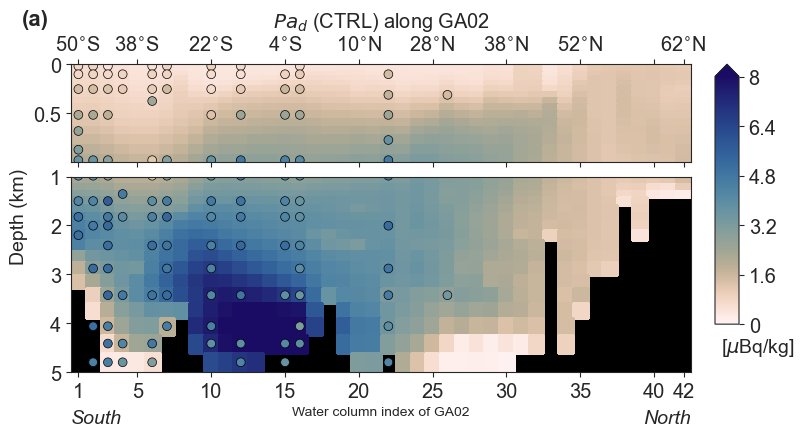

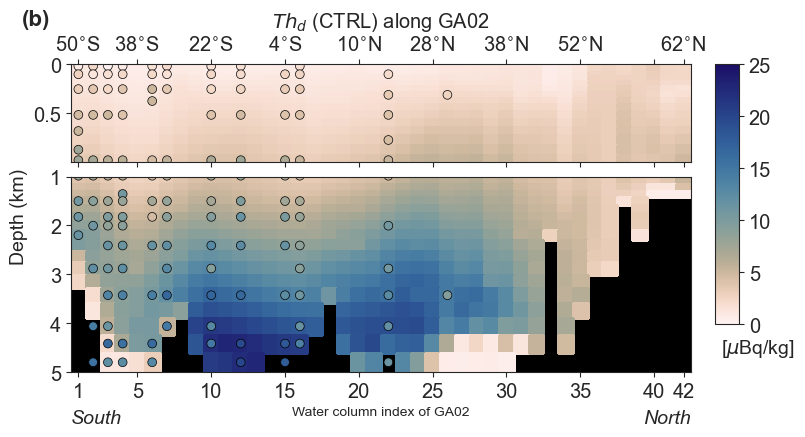

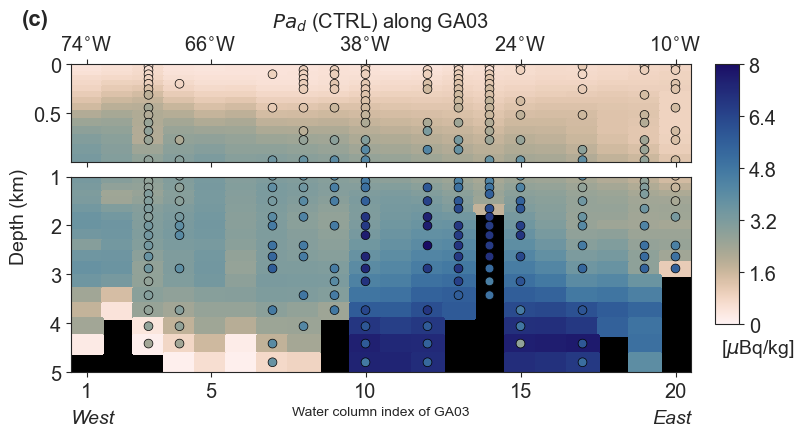

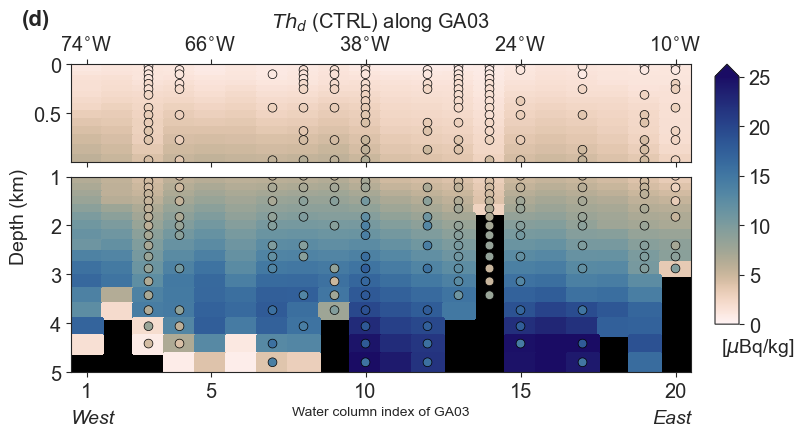

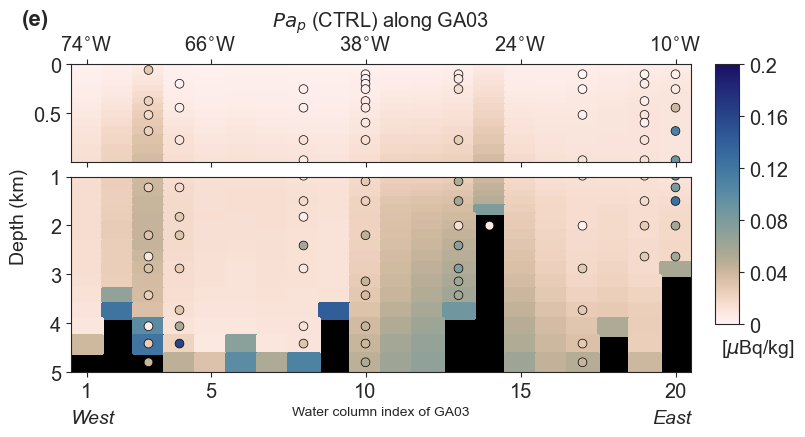

In [12]:
## COMBINE ALL PLOTS FOR ENTIRE ATLANTIC OR PACIFIC
# usually we exclude ng and GAc02 since they only have a few stations (can be changed in cruise_list setting)

# VERSION WITHOUT MAPS

########################## SETTINGS ############################################
run = ctrl
# comment in desired cruise_list below

cmap = cmcr.lapaz_r
this_vmin = 0.0
vmaxs = {'Pad_Bq' : 8, 'Thd_Bq' : 25, 'Pap_Bq' : 0.2, 'Thp_Bq' : 2,
         'path_ratio_d' : 1, 'path_ratio_p' : 0.2}

####### COMMENT IN WHICH FIGURE YOU WANT (COMMENT OUT THE REST): #####

    ############## FIGURE 5 ################
## most interesting Atl cruises:
cruise_list = ['GA02', 'GA03']
out_file_name = str(savedir / ('fig5_Atl_selected_cruises_' + run))

    ############## FIGURE C1 VARIATION - without transect map panels ################
# ## other Atl cruises:
# cruise_list = ['deng', 'GA10', 'GIPY04', 'GIPY05']
# out_file_name = str(savedir / ('figC1_Atl_other_cruises_' + run))

    ######## OTHER SETS TO PLAY AROUND ######
# # all Atl cruises (figure too long for 1 A4):
# cruise_list = ['GA02', 'GA03', 'deng', 'GA10', 'GIPY04', 'GIPY05']
# out_file_name = str(savedir / ('Atl_all_cruises_' + run))  # without .pdf; no spaces

## Atl cruises w/o SO sector:
# cruise_list = ['GA02', 'GA03', 'deng', 'GA10']
# out_file_name = str(savedir / ('Atl_all_cruises_wo_SO_' + run))

## cruises in Atl. SO sector:
# cruise_list = ['GIPY04', 'GIPY05']
# out_file_name = str(savedir / ('Atl_only_SO_cruises_' + run))

## Pac cruises all w/o SO sector:
# cruise_list = ['GP16', 'GIpr05', 'GPc01', 'GSc02', 'pavia']
# out_file_name = str(savedir / ('Pac_all_cruises_' + run))

# # Pac cruises interesting w/o SO sector:
# cruise_list = ['GP16', 'GPc01', 'GSc02']
# out_file_name = str(savedir / ('Pac_selected_cruises_' + run))

#################################################################################
print('run:', run)
print('cruise list:', cruise_list)

basic_data_section = [t, model_coords_per_cruise, cmap, obs_d_ave, obs_p_ave]
basic_data_trajectory = [data_fulls[run], t, model_coords_per_cruise, cmap]
var_label = {'Pad' : '$Pa_d$', 'Pap' : '$Pa_p$', 'Thd' : '$Th_d$', 'Thp' : '$Th_p$',
             'Pad_Bq' : '$Pa_d$', 'Pap_Bq' : '$Pa_p$', 'Thd_Bq' : '$Th_d$', 'Thp_Bq' : '$Th_p$',
             'path_ratio_p' : '$Pa_p/Th_p$', 'path_ratio_d' : 'Pa_d/Th_d'}

nr_rows_counter = 0
panel_nr = 0
with PdfPages(out_file_name+'_raw.pdf') as pdf:
    for this_cruise in cruise_list:
        if this_cruise in ['GA03', 'GIPY04', 'GIPY05', 'GN01', 'GP16']:  # particle-bound obs. available
            p_available = True
            cruise_vars = ['Pad_Bq', 'Thd_Bq', 'Pap_Bq', 'Thp_Bq']
            nr_rows_counter += 2
        else:
            p_available = False
            cruise_vars = ['Pad_Bq', 'Thd_Bq']
            nr_rows_counter += 1

        ## B). plot section for dissolved
        for this_var in ['Pad_Bq', 'Thd_Bq']:
            this_title = var_label[this_var]+' ('+labels[run]+') along '+this_cruise
            fig = f.generate_1_section_plot_fig(dataset=data_fulls[run], variable=this_var, title=this_title,
                                                cruise=this_cruise, basic_data=basic_data_section, 
                                                this_vmin=this_vmin, vmaxs=vmaxs)
            # add label (a), etc.
            this_ax = fig.axes[0]  # first axis contains plot; second contains colourbar
            this_ax.text(-0.08, 1.4, '(' + chr(ord('a')+panel_nr) + ')', transform=this_ax.transAxes, 
                         size=16, weight='bold')
            pdf.savefig(bbox_inches='tight')
            panel_nr += 1

        ## if particle-bound available: create a 2nd row for this cruise
        if p_available:
            ## D). plot section for particle-bound
            for this_var in ['Pap_Bq', 'Thp_Bq']:
                this_title = var_label[this_var]+' ('+labels[run]+') along '+this_cruise
                fig = f.generate_1_section_plot_fig(dataset=data_fulls[run], variable=this_var, title=this_title,
                                                    cruise=this_cruise, basic_data=basic_data_section, 
                                                    this_vmin=this_vmin, vmaxs=vmaxs, avoid_negative=True)
                # add label (a), etc.
                this_ax = fig.axes[0]  # first axis contains plot; second contains colourbar
                this_ax.text(-0.08, 1.4, '(' + chr(ord('a')+panel_nr) + ')', transform=this_ax.transAxes, 
                            size=16, weight='bold')
                pdf.savefig(bbox_inches='tight')
                panel_nr += 1

## COMBINE SUBPLOTS INTO 1 PAGE WITH pdfjam & pdfcrop
print("\nIn order to combine the subpanels & crop white space:\n")
print("!!!!!! THE FOLLOWING 2 LINES NEED TO BE EXECUTED IN THE COMMAND LINE (from the folder of this notebook): !!!!!")
print('pdfjam --nup 2x'+str(nr_rows_counter)+' '+out_file_name+'_raw.pdf --outfile '+out_file_name+'_uncropped.pdf')
print('pdfcrop '+out_file_name+'_uncropped.pdf '+out_file_name+'.pdf')
print('\nAfter that manual step, the resulting figure will be '+out_file_name+'.pdf')

plt.close()

# NEED TO OPEN THE PDF (seems to miss 1 panel as seen from notebook but that is not the case)

**Fig. C1 (Atl other cruises) - with panels of transect maps**

run: CTRL_NEWNR
cruise list: ['deng', 'GA10', 'GIPY04', 'GIPY05']

In order to combine the subpanels & crop white space:

!!!!!! THE FOLLOWING 2 LINES NEED TO BE EXECUTED IN THE COMMAND LINE (from the folder of this notebook): !!!!!
pdfjam --nup 3x6 figures/figC1_Atl_other_cruises_CTRL_NEWNR_raw.pdf --outfile figures/figC1_Atl_other_cruises_CTRL_NEWNR_uncropped.pdf
pdfcrop figures/figC1_Atl_other_cruises_CTRL_NEWNR_uncropped.pdf figures/figC1_Atl_other_cruises_CTRL_NEWNR.pdf

After that manual step, the resulting figure will be figures/figC1_Atl_other_cruises_CTRL_NEWNR.pdf


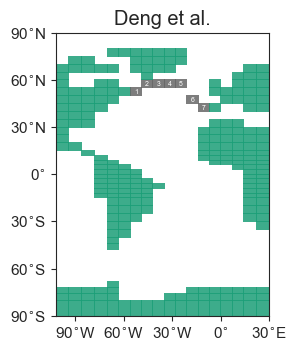

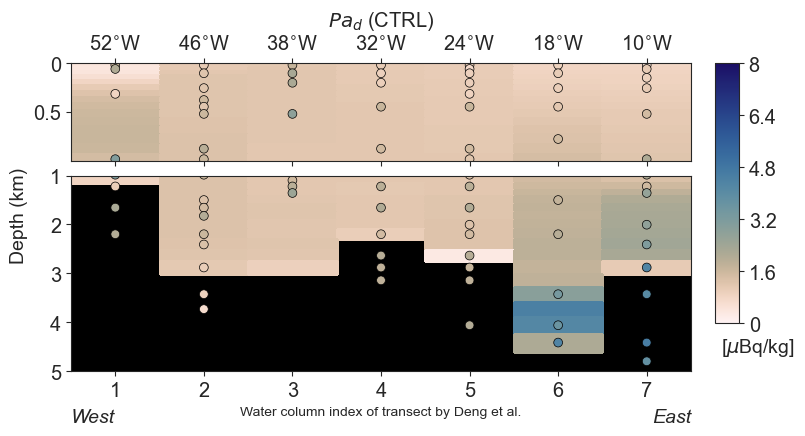

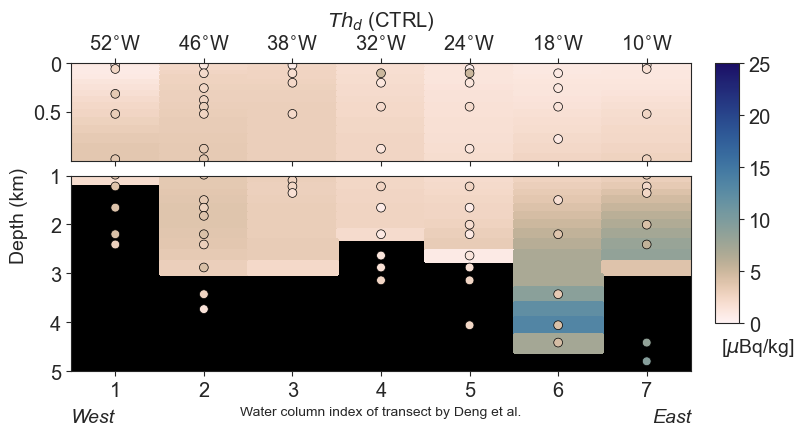

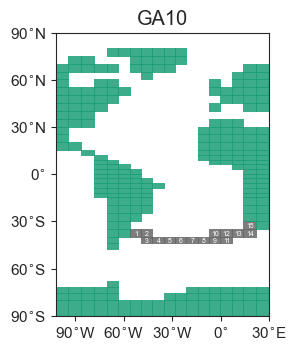

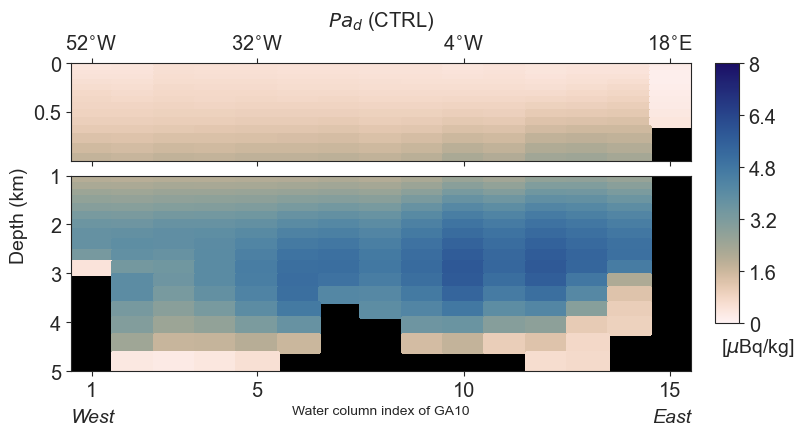

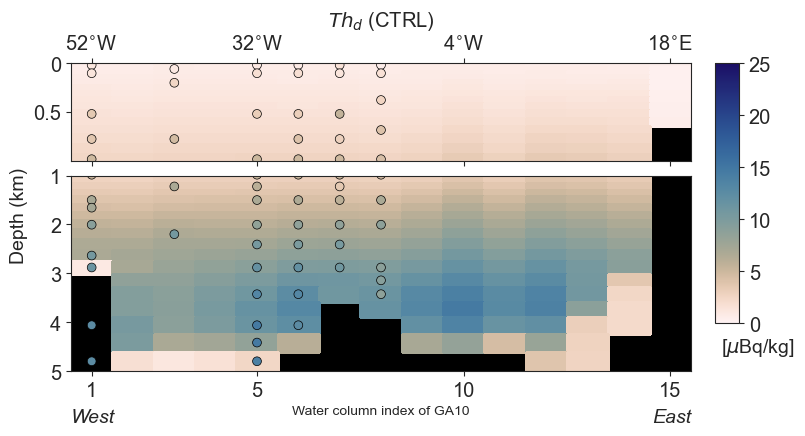

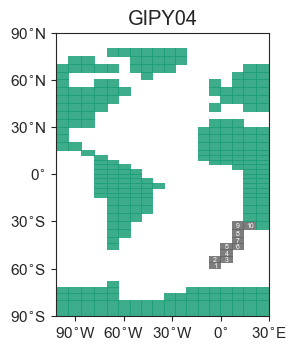

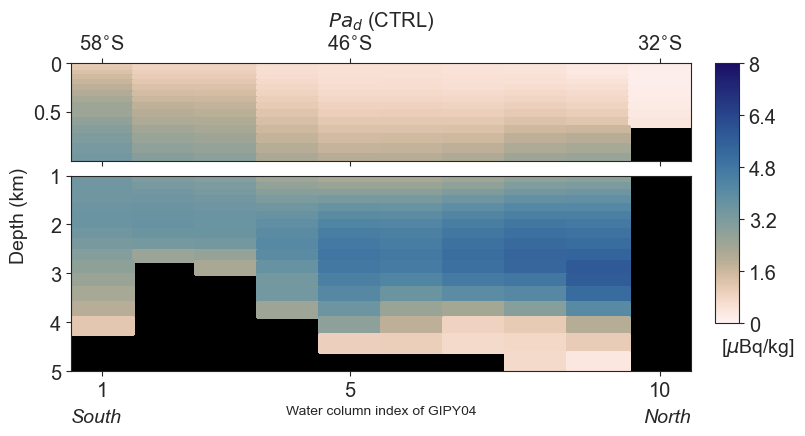

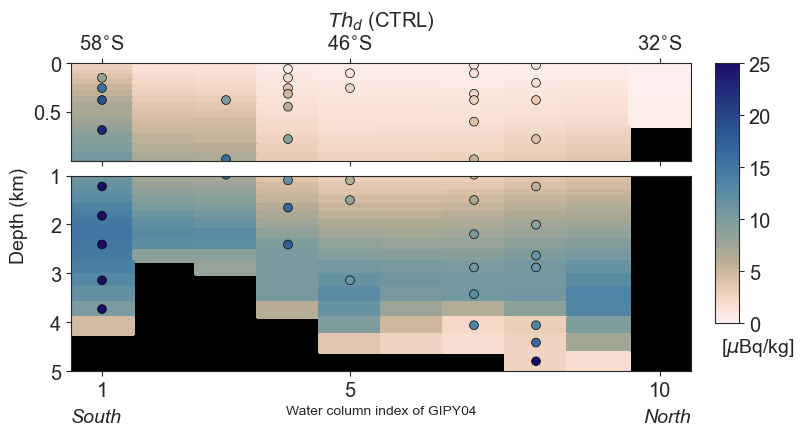

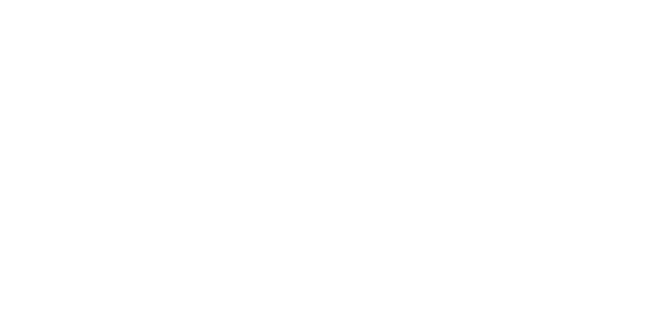

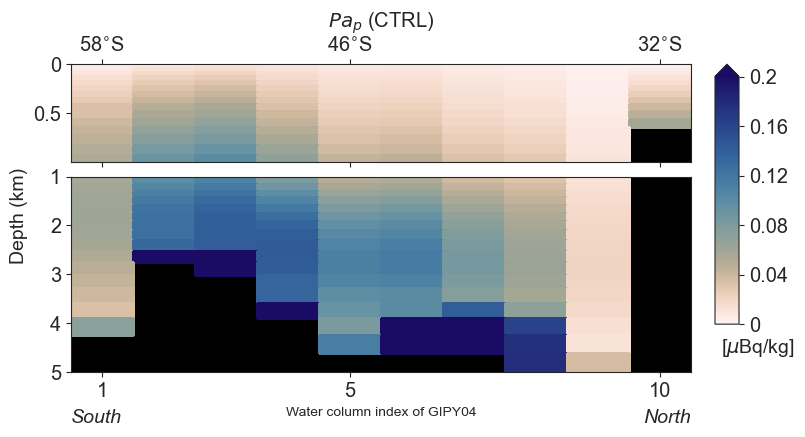

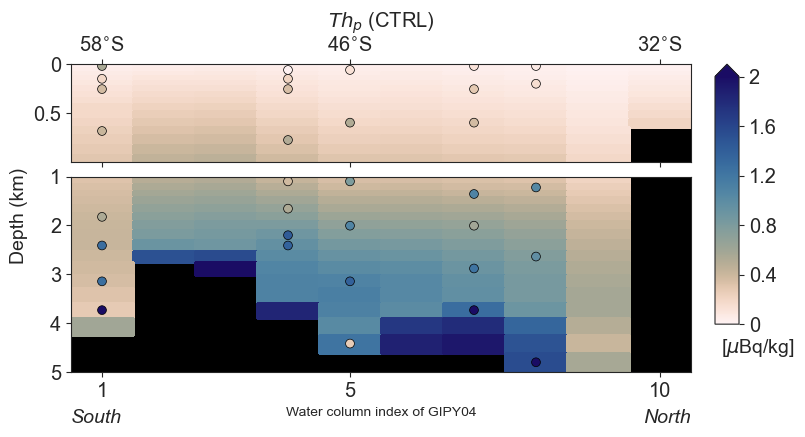

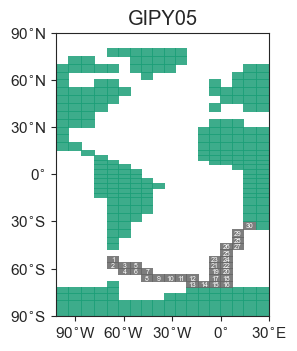

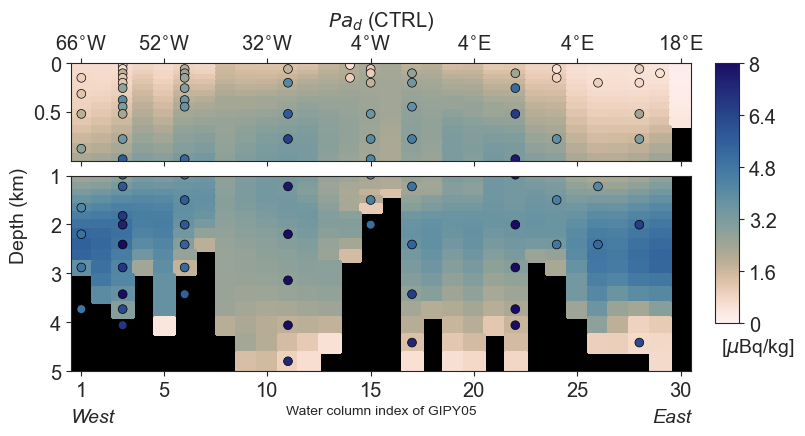

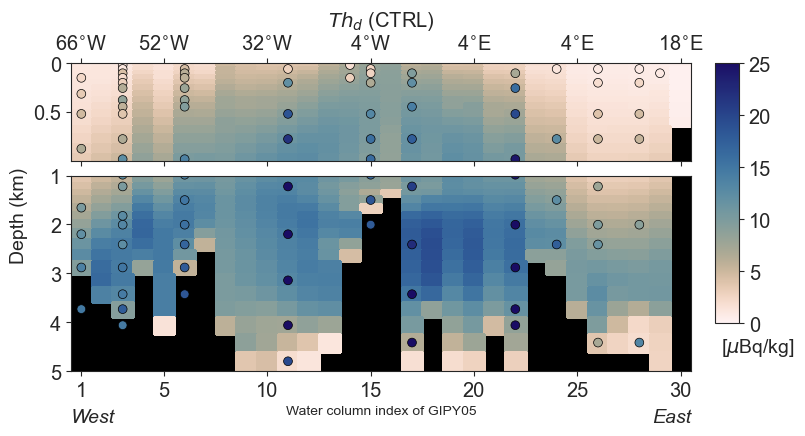

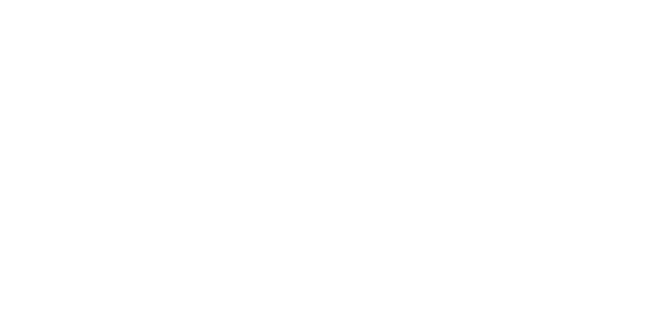

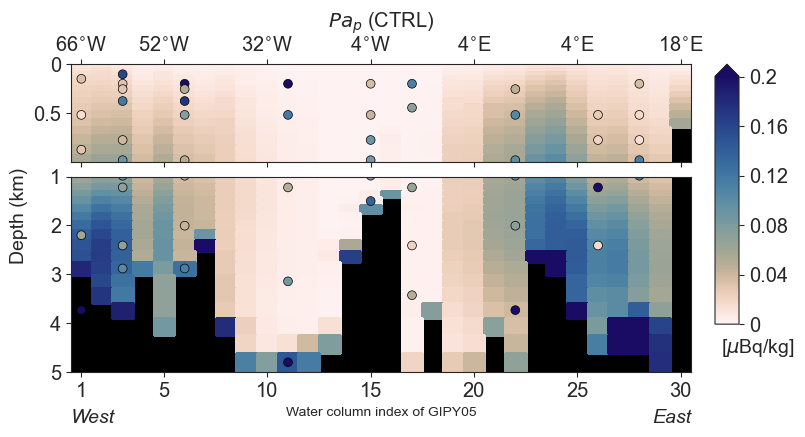

In [13]:
## COMBINE ALL PLOTS FOR ENTIRE ATLANTIC OR PACIFIC
# usually we exclude ng and GAc02 since they only have a few stations (can be changed in cruise_list setting)

# VERSION WITH MAPS

########################## SETTINGS ############################################
run = ctrl
# comment in desired cruise_list below

cmap = cmcr.lapaz_r
this_vmin = 0.0
vmaxs = {'Pad_Bq' : 8, 'Thd_Bq' : 25, 'Pap_Bq' : 0.2, 'Thp_Bq' : 2,
         'path_ratio_d' : 1, 'path_ratio_p' : 0.2}    # my default version
# vmaxs = {'Pad_Bq' : 12, 'Thd_Bq' : 25, 'Pap_Bq' : 0.2, 'Thp_Bq' : 2,
#          'path_ratio_d' : 1, 'path_ratio_p' : 0.2}  # version with higher Pad limit (for Pacific)

####### COMMENT IN WHICH FIGURE YOU WANT (COMMENT OUT THE REST): #####

    ############# FIGURE C1 ################
## other Atl cruises:
cruise_list = ['deng', 'GA10', 'GIPY04', 'GIPY05']
out_file_name = str(savedir / ('figC1_Atl_other_cruises_' + run))

#     ############## OLD FIGURE 5 - with transect map panels ################
# ## most interesting Atl cruises:
# cruise_list = ['GA02', 'GA03']
# out_file_name = str(savedir / ('fig5_Atl_selected_cruises_' + run))

    ######## OTHER SETS TO PLAY AROUND ######
# # all Atl cruises (figure too long for 1 A4):
# cruise_list = ['GA02', 'GA03', 'deng', 'GA10', 'GIPY04', 'GIPY05']
# out_file_name = str(savedir / ('Atl_all_cruises_' + run))  # without .pdf; no spaces

## Atl cruises w/o SO sector:
# cruise_list = ['GA02', 'GA03', 'deng', 'GA10']
# out_file_name = str(savedir / ('Atl_all_cruises_wo_SO_' + run))

## cruises in Atl. SO sector:
# cruise_list = ['GIPY04', 'GIPY05']
# out_file_name = str(savedir / ('Atl_only_SO_cruises_' + run))

# # Pac cruises all w/o SO sector - NOT USEFUL:
# cruise_list = ['GP16', 'GIpr05', 'GPc01', 'GSc02', 'pavia']  # GIPR05 is not Pac; pavia only 1 data point
# out_file_name = str(savedir / ('Pac_all_cruises_' + run))

# # Pac cruises interesting w/o SO sector:
# cruise_list = ['GP16', 'GPc01', 'GSc02']
# out_file_name = str(savedir / ('Pac_selected_cruises_' + run))

#################################################################################
print('run:', run)
print('cruise list:', cruise_list)

basic_data_section = [t, model_coords_per_cruise, cmap, obs_d_ave, obs_p_ave]
basic_data_trajectory = [data_fulls[run], t, model_coords_per_cruise, cmap]
var_label = {'Pad' : '$Pa_d$', 'Pap' : '$Pa_p$', 'Thd' : '$Th_d$', 'Thp' : '$Th_p$',
             'Pad_Bq' : '$Pa_d$', 'Pap_Bq' : '$Pa_p$', 'Thd_Bq' : '$Th_d$', 'Thp_Bq' : '$Th_p$',
             'path_ratio_p' : '$Pa_p/Th_p$', 'path_ratio_d' : 'Pa_d/Th_d'}

nr_rows_counter = 0
with PdfPages(out_file_name+'_raw.pdf') as pdf:
    for this_cruise in cruise_list:
        if this_cruise in ['GA03', 'GIPY04', 'GIPY05', 'GN01', 'GP16']:  # particle-bound obs. available
            p_available = True
            cruise_vars = ['Pad_Bq', 'Thd_Bq', 'Pap_Bq', 'Thp_Bq']
            nr_rows_counter += 2
        else:
            p_available = False
            cruise_vars = ['Pad_Bq', 'Thd_Bq']
            nr_rows_counter += 1

        ## A). first generate trajectory map for this cruise WITH whitespace on the left (once)

        # temporarily change global parameter to NOT cut off whitespace
        matplotlib.rcParams['savefig.bbox'] = 'standard'

        fig = f.generate_trajectory_fig(cruise=this_cruise, basic_data=basic_data_trajectory)

        # overwriting the (2.5,4) for Atlantic zoom to (8,4) + extra width for cbar in transect plot:
        fig.set_size_inches(8.134,4)
        # start subplot rectangle at left=68.75% of width s.t. same ratio stays the same(5.5/8=0.6875); others s.t. align with transect plot
        plt.subplots_adjust(left=0.6875, right=0.95, top=0.858, bottom=0.15)

        pdf.savefig()

        # set back global parameter as desired in the rest of the notebook
        matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace

        if p_available:
            # save figure size of map to use below
            map_width, map_height = fig.get_size_inches()

        ## B). then plot section for dissolved
        for this_var in ['Pad_Bq', 'Thd_Bq']:
            this_title = var_label[this_var]+' ('+labels[run]+')'
            fig = f.generate_1_section_plot_fig(dataset=data_fulls[run], variable=this_var, title=this_title,
                                                cruise=this_cruise, basic_data=basic_data_section, 
                                                this_vmin=this_vmin, vmaxs=vmaxs)
            pdf.savefig(bbox_inches='tight')

        ## if particle-bound available: create a 2nd row for this cruise
        if p_available:
            ## C). create 1 empty map figure to align
            fig, ax = plt.subplots(1,figsize=(map_width, map_height))
            ax.set_axis_off()
            pdf.savefig(fig)

            ## D). then plot section for particle-bound
            for this_var in ['Pap_Bq', 'Thp_Bq']:
                this_title = var_label[this_var]+' ('+labels[run]+')'
                fig = f.generate_1_section_plot_fig(dataset=data_fulls[run], variable=this_var, title=this_title,
                                                    cruise=this_cruise, basic_data=basic_data_section, 
                                                    this_vmin=this_vmin, vmaxs=vmaxs, avoid_negative=True)
                pdf.savefig(bbox_inches='tight')

## COMBINE SUBPLOTS INTO 1 PAGE WITH pdfjam & pdfcrop
print("\nIn order to combine the subpanels & crop white space:\n")
print("!!!!!! THE FOLLOWING 2 LINES NEED TO BE EXECUTED IN THE COMMAND LINE (from the folder of this notebook): !!!!!")
print('pdfjam --nup 3x'+str(nr_rows_counter)+' '+out_file_name+'_raw.pdf --outfile '+out_file_name+'_uncropped.pdf')
print('pdfcrop '+out_file_name+'_uncropped.pdf '+out_file_name+'.pdf')
print('\nAfter that manual step, the resulting figure will be '+out_file_name+'.pdf')

plt.close()

## Fig. 11: sensitivity

cruise list: ['GA02', 'GA03']

In order to combine the 6 subpanels & crop white space:

!!!!!! THE FOLLOWING 2 LINES NEED TO BE EXECUTED IN THE COMMAND LINE (from the folder of this notebook): !!!!!
pdfjam --nup 2x2 figures/fig11_Atl_cruises_p_sensitivity_before_ppt_raw.pdf --outfile figures/fig11_Atl_cruises_p_sensitivity_before_ppt_uncropped.pdf
pdfcrop figures/fig11_Atl_cruises_p_sensitivity_before_ppt_uncropped.pdf figures/fig11_Atl_cruises_p_sensitivity_before_ppt.pdf

After that manual step, the resulting figure will be figures/fig11_Atl_cruises_p_sensitivity_before_ppt.pdf


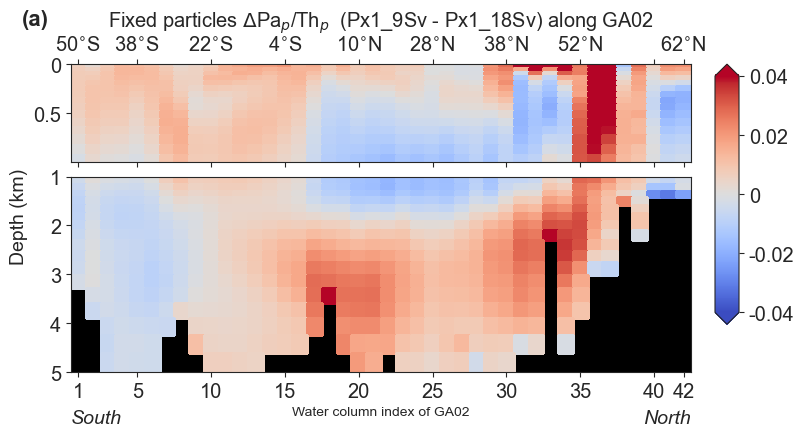

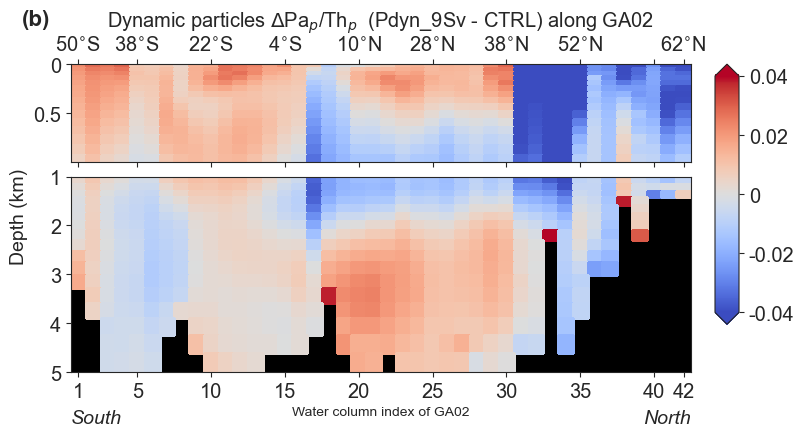

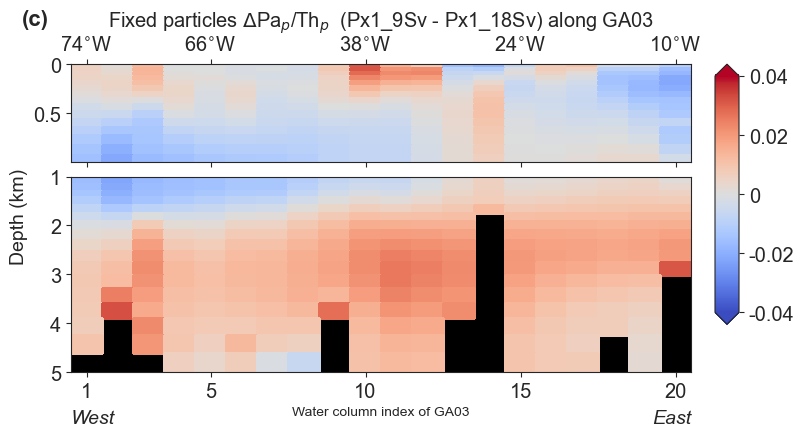

In [14]:
# sensitivity plot along transects GA02 and GA03

#### SETTINGS ########################################
# runs are set below in runs_per_column
cruise_list = ['GA02', 'GA03']  # most interesting Atl cruises

out_file_name = str(savedir / ('fig11_Atl_cruises_p_sensitivity_before_ppt'))  # without .pdf; no spaces; will annotate regions later in ppt
cmap = cmp.coolwarm
vmaxs = {'Pad_Bq' : 8, 'Thd_Bq' : 25, 'Pap_Bq' : 0.2, 'Thp_Bq' : 2,
         'path_ratio_d' : 1, 'path_ratio_p' : 0.04}
vmins = {'Pad_Bq' : -vmaxs['Pad_Bq'], 'Thd_Bq' : -vmaxs['Thd_Bq'], 'Pap_Bq' : -vmaxs['Pap_Bq'], 'Thp_Bq' : -vmaxs['Thp_Bq'],
         'path_ratio_d' : -vmaxs['path_ratio_d'], 'path_ratio_p' : -vmaxs['path_ratio_p']}
levels = 8
#### END OF SETTINGS ################################
print('cruise list:', cruise_list)

this_var = 'path_ratio_p'
runs_per_column = [[PFX1__09SV, PFX1__18SV],
                   [PFREE_09SV, ctrl]]
labels_per_column = ['Fixed particles $\Delta$Pa$_p$/Th$_p$',
                     'Dynamic particles $\Delta$Pa$_p$/Th$_p$'] 

basic_data_section = [t, model_coords_per_cruise, cmap, obs_d_ave, obs_p_ave]
basic_data_trajectory = [data_fulls[run], t, model_coords_per_cruise, cmap]  # stick to 1 run's dataset because uses mask
var_label = {'Pad' : '$Pa_d$', 'Pap' : '$Pa_p$', 'Thd' : '$Th_d$', 'Thp' : '$Th_p$',
             'Pad_Bq' : '$Pa_d$', 'Pap_Bq' : '$Pa_p$', 'Thd_Bq' : '$Th_d$', 'Thp_Bq' : '$Th_p$',
             'path_ratio_p' : '$Pa_p/Th_p$', 'path_ratio_d' : 'Pa_d/Th_d'}

# make dataset run1 minus run2
vars_to_keep = ['Pad', 'Thd', 'Pap', 'Thp', 
                'Pad_Bq', 'Thd_Bq', 'Pap_Bq', 'Thp_Bq', 
                'path_ratio_p', 'path_ratio_d', 
                'lat_t','lon_t','lat_u','lon_u','z_t','z_w']

runs_diff = []
for col in [0,1]:
    runs_diff.append(f.drop_most_vars(data_fulls[runs_per_column[col][0]], vars_to_keep=vars_to_keep) - 
                     f.drop_most_vars(data_fulls[runs_per_column[col][1]], vars_to_keep=vars_to_keep))

nr_rows_counter = 0
panel_nr = 0
with PdfPages(out_file_name+'_raw.pdf') as pdf:
    for this_cruise in cruise_list:
        nr_rows_counter += 1
        ## B). & C.) plot Pa/Th ratio for column 1 (PI particles x1) and 2 (Dynamic particles)
        for col in [0,1]:
            title = labels_per_column[col] + '  (' + labels[runs_per_column[col][0]] + ' - ' + labels[runs_per_column[col][1]] + ') along ' + this_cruise
            fig = f.generate_1_section_plot_fig(dataset=runs_diff[col], variable=this_var, title=title,
                                                cruise=this_cruise, basic_data=basic_data_section, 
                                                this_vmin=vmins[this_var], vmaxs=vmaxs, levels=levels,
                                                # this_vmin=None, vmaxs={str(this_var) : None},  # to look at automatic range
                                                cbar_extend_both=True, obs=False) # force both cbar arrows because anomaly plot
            # add label (a), etc.
            this_ax = fig.axes[0]  # first axis contains plot; second contains colourbar
            this_ax.text(-0.08, 1.4, '(' + chr(ord('a')+panel_nr) + ')', transform=this_ax.transAxes, 
                        size=16, weight='bold')
            pdf.savefig(bbox_inches='tight')
            panel_nr += 1

## COMBINE SUBPLOTS INTO 1 PAGE WITH pdfjam & pdfcrop
print("\nIn order to combine the 6 subpanels & crop white space:\n")
print("!!!!!! THE FOLLOWING 2 LINES NEED TO BE EXECUTED IN THE COMMAND LINE (from the folder of this notebook): !!!!!")
print('pdfjam --nup 2x'+str(nr_rows_counter)+' '+out_file_name+'_raw.pdf --outfile '+out_file_name+'_uncropped.pdf')
print('pdfcrop '+out_file_name+'_uncropped.pdf '+out_file_name+'.pdf')
print('\nAfter that manual step, the resulting figure will be '+out_file_name+'.pdf')

plt.close()

# NEED TO OPEN THE PDF (seems to miss 1 panel as seen from notebook but that is not the case)

A visual indication of regions 1-4 is added for the GA02 panels in powerpoint in fig11_mark_regions.pptx.